# 2018.11.01: Network inference from time series of cartegorical variables
## eps = 1 if A, -1 otherwise

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 5 # number of values at each position
l = 4*((n*m)**2) # number of samples

g = 1.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            
        
    return w

In [5]:
w0 = generate_coupling(n,m,g)

In [6]:
# 2018.10.27: generate time series by MCMC
def generate_sequences_MCMC(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 100

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s            

In [7]:
s = generate_sequences_MCMC(w0,n,m,l) 

In [8]:
#print(s[:5])

In [9]:
# recover s0 from s
s0 = np.argmax(s.reshape(-1,m),axis=1).reshape(-1,n)

In [10]:
def eps_ab_func(s0,m):
    l,n = s0.shape
    eps = np.zeros((n,l-1,m,m))
    eps[:,:,:] = -1.
    for i in range(n):
        for t in range(l-1):            
            #eps[i,t,:,int(s0[t+1,i])] = -1.
            eps[i,t,int(s0[t+1,i]),:] = 1.
    return eps

In [11]:
eps_ab_all = eps_ab_func(s0,m)

In [12]:
l = s.shape[0]

s_av = np.mean(s[:-1],axis=0)
ds = s[:-1] - s_av
c = np.cov(ds,rowvar=False,bias=True)
#print(c)

c_inv = linalg.pinv(c,rcond=1e-15)
#print(c_inv)

nm = n*m
nloop = 5

wini = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))

w_infer = np.zeros((nm,nm))

for i in range(n):
    i1,i2 = i1tab[i],i2tab[i]

    w_true = w0[i1:i2,:]
    w = wini[i1:i2,:].copy()
    #h = s[1:,i1:i2].copy()

    for iloop in range(nloop):
        h = np.dot(s[:-1],w.T)

        for ia in range(m):
            for t in range(l-1):
                if s[t+1,i1+ia] == 1.:            
                    ha = 0.
                    for ib in range(m):
                        if ib != ia: 
                            hab = (h[t,ia] - h[t,ib])
                            if hab != 0: ha += hab/np.tanh(hab/2.)                            
                    h[t,ia] = ha/float(m)

        h_av = h.mean(axis=0)
        dh = h - h_av

        dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
        dhds_av = dhds.mean(axis=0)

        w = np.dot(dhds_av,c_inv)

        mse = ((w_true - w)**2).mean()   
        slope = (w_true*w).sum()/(w_true**2).sum()  
        print(i,iloop,mse,slope)

    w_infer[i1:i2,:] = w    

(0, 0, 0.01650415635522309, 0.2599834517742022)
(0, 1, 0.010272511121572998, 0.534266437851958)
(0, 2, 0.006479441082736734, 0.7454389677579049)
(0, 3, 0.008259505847936131, 0.9302420132338322)
(0, 4, 0.00988358095561647, 1.0465015920689946)
(1, 0, 0.024279949332132154, 0.17486518493017142)
(1, 1, 0.013219356375883213, 0.45115084596057037)
(1, 2, 0.00901004046387846, 0.6740060283576919)
(1, 3, 0.007480762958022195, 0.8512164957770817)
(1, 4, 0.008466435544756632, 1.015927204209738)
(2, 0, 0.019014814278576174, 0.26379087809144863)
(2, 1, 0.011409874092695036, 0.5100864569220188)
(2, 2, 0.007500519260261671, 0.7099843052089317)
(2, 3, 0.006834994512821264, 0.8713660585800288)
(2, 4, 0.008008026136255578, 0.9937723810602836)
(3, 0, 0.024291139363344604, 0.37334025561481726)
(3, 1, 0.015285707570036357, 0.61562452846578)
(3, 2, 0.00987957053186727, 0.8225734603516831)
(3, 3, 0.009805047503675873, 0.9902111876391885)
(3, 4, 0.008896814607651364, 1.119200554459132)
(4, 0, 0.0163584259878576

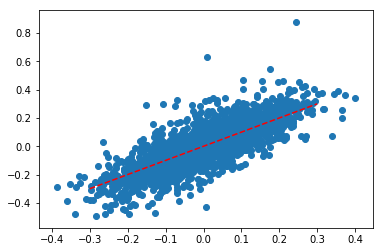

In [13]:
plt.scatter(w0,w_infer)
plt.plot([-0.3,0.3],[-0.3,0.3],'r--')